# Match truth and object catalogs for DC2 Run 1.2i
Owner: Yao-Yuan Mao, Scott Daniel (with help from Anže Slosar, Bhairav Valera, HyeYun Park) <br>
Last Verified to Run: 2018-11-19

**Notes:**
- Follow this [step-by-step guide](https://confluence.slac.stanford.edu/x/Xgg4Dg) if you don't know how to run this notebook.
- If you need more information about the Generic Catalog Reader (GCR), see [this diagram](https://github.com/yymao/generic-catalog-reader/blob/master/README.md#concept) and [more examples](https://github.com/LSSTDESC/gcr-catalogs/blob/master/examples/GCRCatalogs%20Demo.ipynb).

## Learning objectives
After completing and studying this Notebook, you should be able to:
  1. Use GCR to load object catalog and truth catalog
  2. Use `filters` and `native_filters` appropriately
  3. Use `add_quantity_modifier` and `get_quantity_modifier`
  4. Use `FoFCatalogMatching` to do Friends-of-friends catalog matching
  5. Learn some cool Numpy tricks for binning, masking, and reshaping [Advanced]
  6. Learn use pandas to match truth catalog object id back to the galaxy id in extragalactic catalog [advanced]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from astropy.coordinates import SkyCoord
import FoFCatalogMatching
import GCRCatalogs

In [3]:
# load object catalog (for a single tract)
object_cat = GCRCatalogs.load_catalog('dc2_object_run1.2i_all_columns')

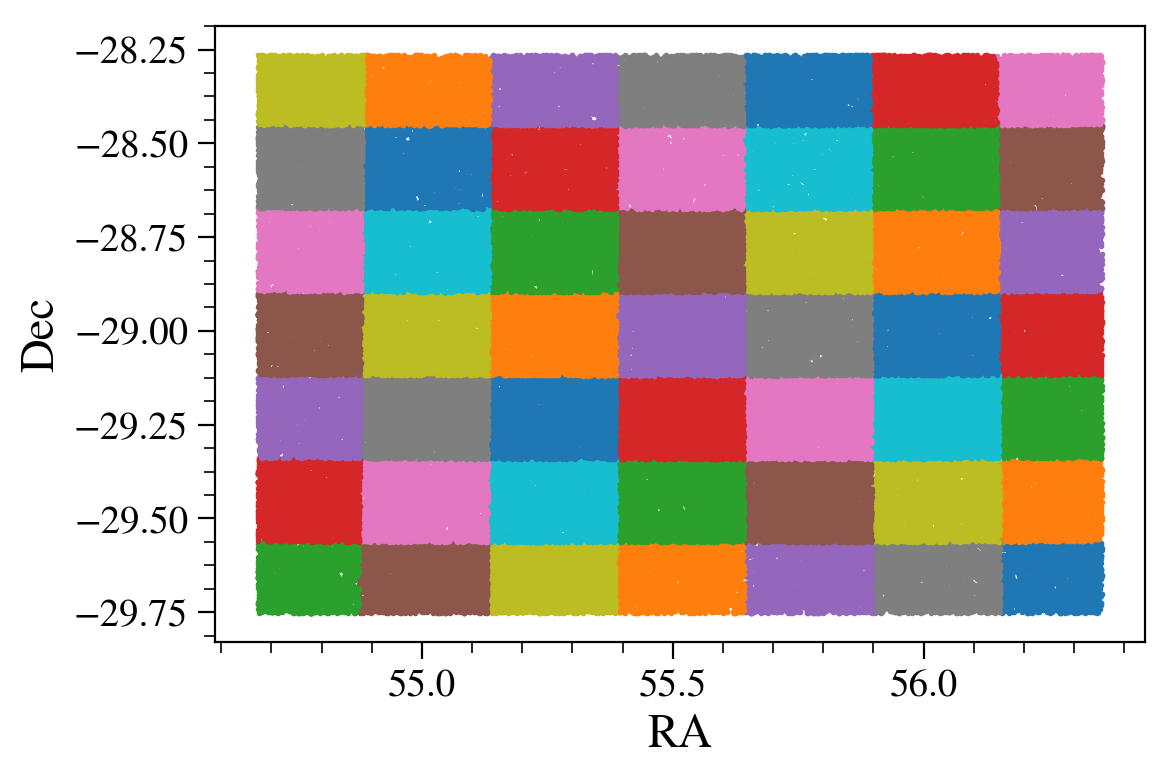

In [4]:
# Let's first visually inspect the footprint of one tract of the object catalog.
# When `return_iterator` is turned on, the method `get_quantities` will return an 
# iterator, and each element in the iterator will be the quantities we requested in 
# different chunks of the dataset. 

# For object catalogs, the different chunks happen to be different patches, 
# resulting in a different color for each patch in the scatter plot below.

for object_data in object_cat.get_quantities(['ra', 'dec'], native_filters=['tract == 4850'], return_iterator=True):
    plt.scatter(object_data['ra'], object_data['dec'], s=1, rasterized=True);

plt.xlabel('RA');
plt.ylabel('Dec');

In [5]:
# Let's choose a small RA and Dec range to do the matching so that it won't take too long!
ra_min, ra_max = 55.5, 56.0
dec_min, dec_max = -29.0, -28.5

coord_filters = [
    'ra >= {}'.format(ra_min),
    'ra < {}'.format(ra_max),
    'dec >= {}'.format(dec_min),
    'dec < {}'.format(dec_max),
]

In [6]:
# Let's also define a magnitude cut
mag_filters = [
    (np.isfinite, 'mag_i'),
    'mag_i < 24.5',
]

In [7]:
# let's add total ellipticity for later use (not needed for now)
object_cat.add_derived_quantity('shape_hsm_regauss_etot', np.hypot, 'ext_shapeHSM_HsmShapeRegauss_e1', 'ext_shapeHSM_HsmShapeRegauss_e2')

In [8]:
# Load ra and dec from object, using both of the filters we just defined.
object_data = object_cat.get_quantities(['ra', 'dec', 'mag_i_cModel', 'shape_hsm_regauss_etot'], filters=(coord_filters + mag_filters), native_filters=['tract == 4850'])

In [9]:
# Let's now turn to the truth catalog
truth_cat = GCRCatalogs.load_catalog('dc2_truth_run1.2_static')

In [10]:
# for a reason that we will soon see, let's inspect the quantities in truth catalog

print(sorted(truth_cat.list_all_quantities()))
print('---')
print(sorted(truth_cat.list_all_native_quantities()))

['agn', 'mag_true_g', 'mag_true_i', 'mag_true_r', 'mag_true_u', 'mag_true_y', 'mag_true_z', 'sprinkled', 'star']
---
['agn', 'dec', 'g', 'healpix_2048', 'i', 'object_id', 'r', 'ra', 'redshift', 'sprinkled', 'star', 'u', 'y', 'z']


In [11]:
# so we see there is no mag_i, but only mag_true_i (i.e., magnitude before lensing)
# to make our `mag_filters` work, let's define mag_i for the truth catalog
truth_cat.add_quantity_modifier('mag_i', truth_cat.get_quantity_modifier('mag_true_i'))

In [12]:
# get ra and dec from truth catalog
# note that we add i < 24.5 to the native filter to speed up load time
truth_native_filters = (coord_filters + ['i < 24.5'])
truth_data = truth_cat.get_quantities(['ra', 'dec', 'object_id', 'star', 'sprinkled'], filters=mag_filters, native_filters=truth_native_filters)

# We will use the object_id, star, and sprinkled columns when cross-referencing truth information with the extragalactic catalog.

In [13]:
# now we can really do the matching!
# FoFCatalogMatching.match takes a dictionary of catalogs to match, a friends-of-friends linking length. 
# Because our "catalog" is not an astropy table or pandas dataframe, 
# `len(truth_coord)` won't give the actual length of the table
# so we need to specify `catalog_len_getter` so that the code knows how to get the length of the catalog.

results = FoFCatalogMatching.match(
    catalog_dict={'truth': truth_data, 'object': object_data},
    linking_lengths=1.0,
    catalog_len_getter=lambda x: len(x['ra']),
)

In [14]:
# return of FoFCatalogMatching.match is an astropy table
results

row_index,catalog_key,group_id
int64,str6,int64
0,truth,0
1021,object,0
1,truth,1
1015,object,1
2,truth,2
1303,object,2
3,truth,3
1025,object,3
4,truth,4


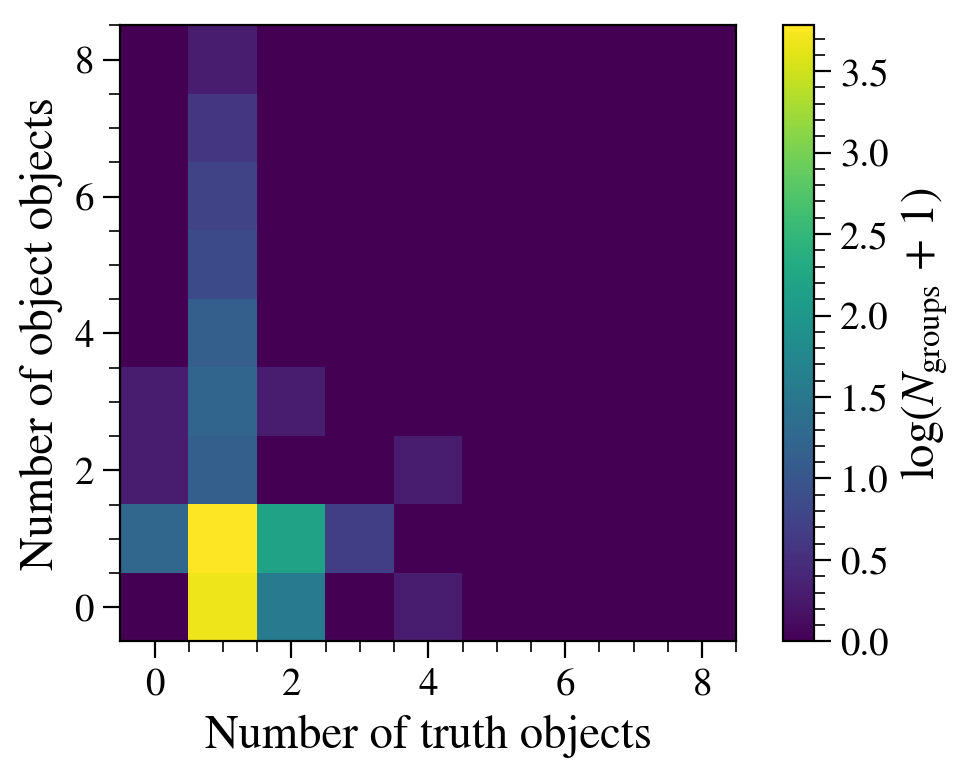

In [15]:
# now we want to count the number of truth and object objects *for each group*
# but instead of looping over groups, we can do this in a smart (and very fast) way

# first we need to know which rows are from the truth catalog and which are from the object
truth_mask = results['catalog_key'] == 'truth'
object_mask = ~truth_mask

# then np.bincount will give up the number of id occurrences (like historgram but with integer input)
n_groups = results['group_id'].max() + 1
n_truth = np.bincount(results['group_id'][truth_mask], minlength=n_groups)
n_object = np.bincount(results['group_id'][object_mask], minlength=n_groups)

# now n_truth and n_object are the number of truth/object objects in each group
# we want to make a 2d histrogram of (n_truth, n_object). 
n_max = max(n_truth.max(), n_object.max()) + 1
hist_2d = np.bincount(n_object * n_max + n_truth, minlength=n_max*n_max).reshape(n_max, n_max)

plt.imshow(np.log10(hist_2d+1), extent=(-0.5, n_max-0.5, -0.5, n_max-0.5), origin='lower');
plt.xlabel('Number of truth objects');
plt.ylabel('Number of object objects');
plt.colorbar(label=r'$\log(N_{\rm groups} \, + \, 1)$');

In [16]:
# Let's further inspect the objects in the groups that have 1-to-1 truth/object match.

# first, let's find our the IDs of the groups that have 1-to-1 truth/object match:
one_to_one_group_mask = np.in1d(results['group_id'], np.flatnonzero((n_truth == 1) & (n_object == 1)))

# and then we can find the row indices in the *original* truth/object catalogs for those 1-to-1 groups
truth_idx = results['row_index'][one_to_one_group_mask & truth_mask]
object_idx = results['row_index'][one_to_one_group_mask & object_mask]

In [17]:
truth_sc = SkyCoord(truth_data['ra'][truth_idx], truth_data['dec'][truth_idx], unit="deg")
object_sc = SkyCoord(object_data['ra'][object_idx], object_data['dec'][object_idx], unit="deg")

delta_ra = (object_sc.ra.arcsec - truth_sc.ra.arcsec) * np.cos(np.deg2rad(0.5*(truth_sc.dec.deg + object_sc.dec.deg)))
delta_dec = object_sc.dec.arcsec - truth_sc.dec.arcsec
delta_arcsec = object_sc.separation(truth_sc).arcsec

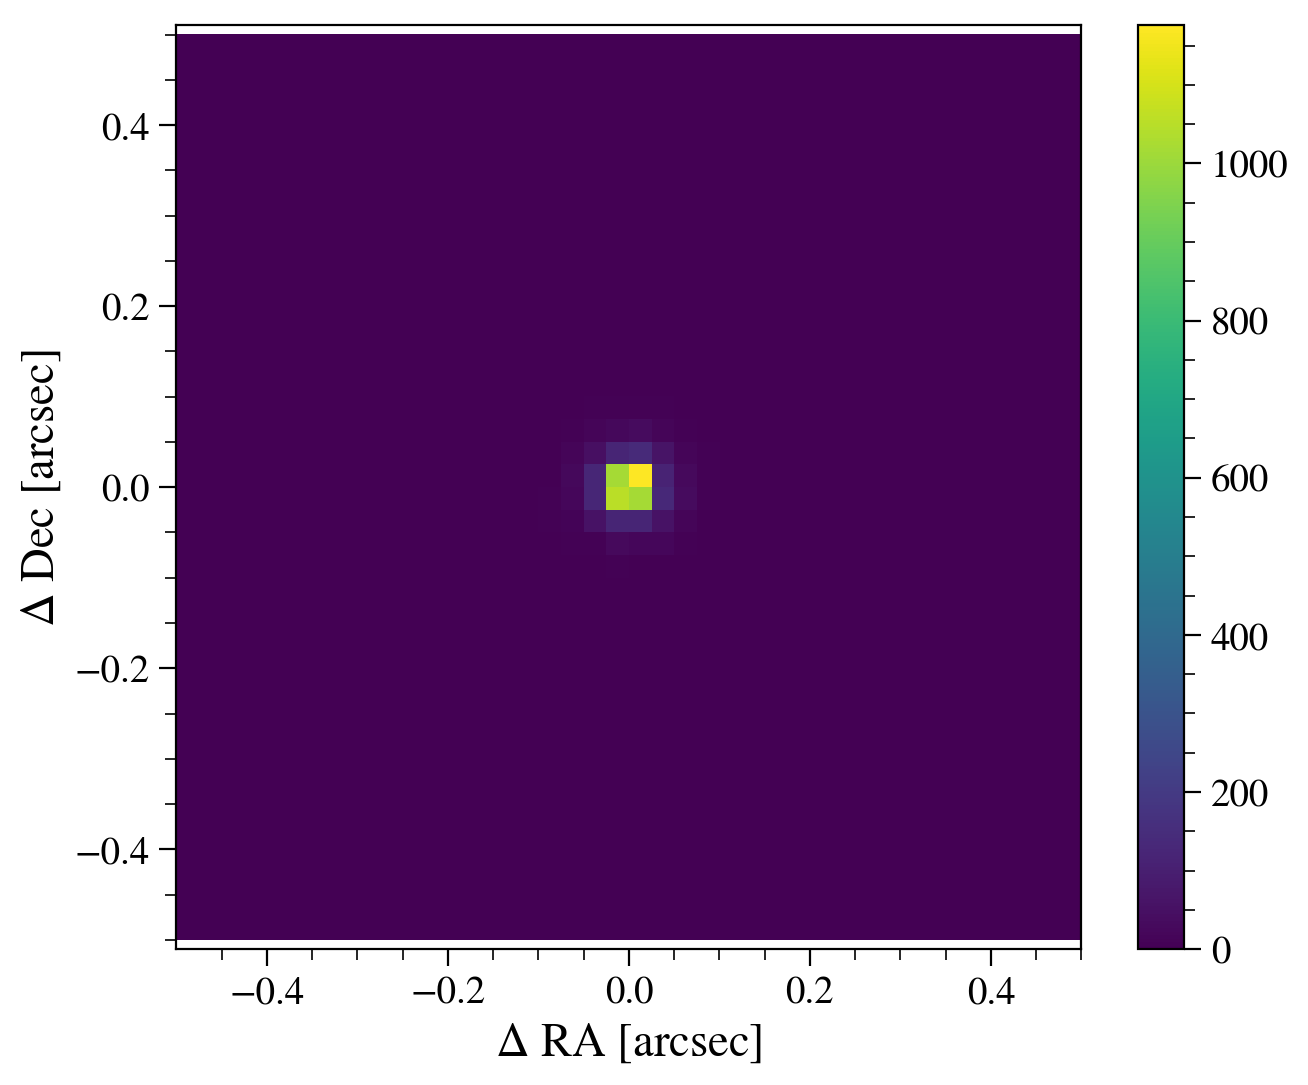

In [18]:
plt.figure(figsize=(7.3, 6))  # Pick a figuresize that will result in a square equal-axis plus colorbar
plt.hist2d(delta_ra, delta_dec, bins=40, range=((-0.5, +0.5), (-0.5, +0.5)));
plt.xlabel(r'$\Delta$ RA [arcsec]');
plt.ylabel(r'$\Delta$ Dec [arcsec]');
plt.colorbar();
plt.xlim(-0.5, +0.5)
plt.ylim(-0.5, +0.5)
plt.axis('equal');

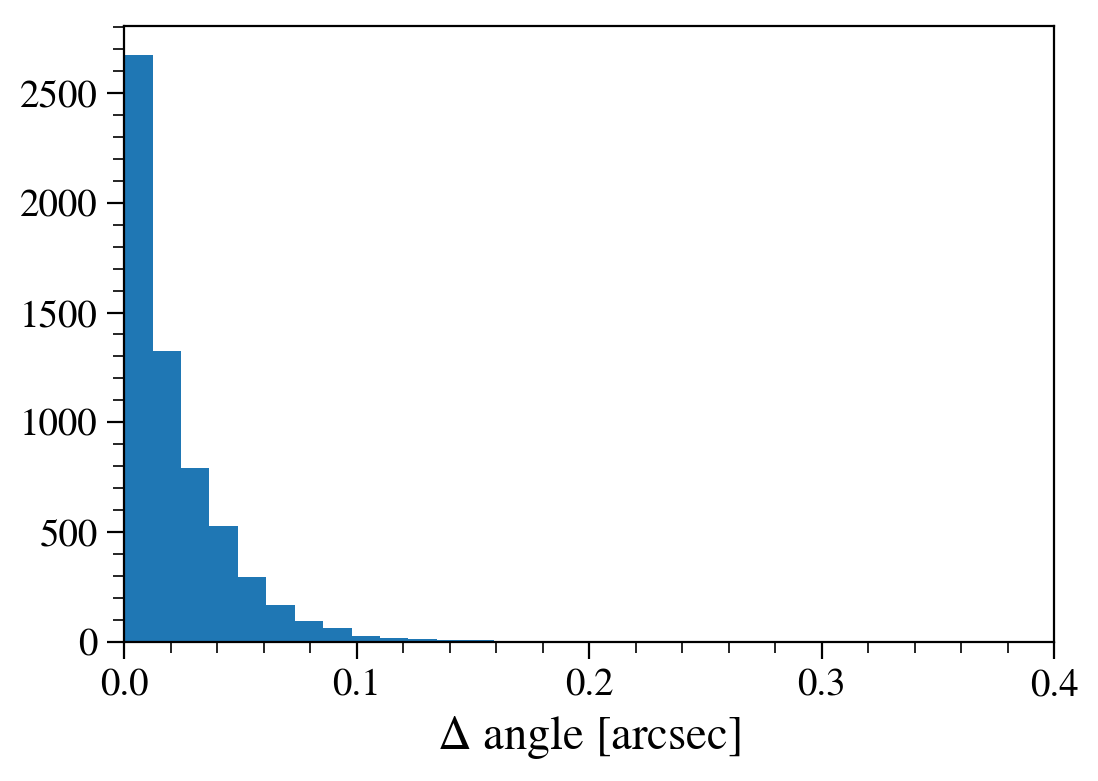

In [19]:
#Plotting Delta angle for the outputs
plt.hist(delta_arcsec, bins=80);
plt.xlim(0, 0.4);
plt.xlabel(r'$\Delta$ angle [arcsec]');

### Going one step further

Most of the astrophysical truth information about the objects in DC2 is actually stored in the extragalactic catalog.  The truth catalog only contains the positions and magnitudes that we believe should have been produced by the image simulators.  To access further truth information (redshift, shape parameters, mass), we must cross-reference the truth catalog with the extragalactic catalog.  This can be done via the column `object_id` in the truth catalog, which maps directly to `galaxy_id` in the extragalactic catalog.

Let's use pandas for this part to make our lives a bit easier :) 

In [20]:
import pandas as pd

In [21]:
# convert truth_data and object_data to pandas dataframe and select the matched one
truth_matched = pd.DataFrame(truth_data).iloc[truth_idx].reset_index(drop=True)
object_matched = pd.DataFrame(object_data).iloc[object_idx].reset_index(drop=True)
matched = pd.merge(truth_matched, object_matched, left_index=True, right_index=True, suffixes=('_truth', '_object'))

In [22]:
# Select only those truth objects that are galaxies which were not sprinkled
# (stars and sprinkled objects do not occur in the extragalactic catalog)
matched_gals = matched.query('~star').query('~sprinkled')

In [23]:
# First, load the extragalactic catalog that was used for this simulation (using _test to skip md5 check)
extragalactic_cat = GCRCatalogs.load_catalog('proto-dc2_v3.0_test')

/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/GCRCatalogs/alphaq.py:105: UserWarning: No md5 sum specified in the config file
  warnings.warn('No md5 sum specified in the config file')


In [24]:
# load redshift and shear parameters from the extragalactic catalog, only for galaxise that are already in `matched_gals`
extragalactic_data = extragalactic_cat.get_quantities(
    ['galaxy_id', 'mag_i_lsst', 'ellipticity_true', 'shear_1', 'shear_2'],
    filters=[(lambda x: np.in1d(x, matched_gals['object_id'].values, True), 'galaxy_id')]
)

In [25]:
# merge extragalactic_data to matched_gals
matched_gals = pd.merge(matched_gals, pd.DataFrame(extragalactic_data), 'left', left_on='object_id', right_on='galaxy_id')

In [26]:
np.testing.assert_array_equal(matched_gals['object_id'], matched_gals['galaxy_id'])

In [27]:
# check out the table 
matched_gals

,sprinkled,ra_truth,object_id,dec_truth,star,dec_object,shape_hsm_regauss_etot,mag_i_cModel,ra_object,mag_i_lsst,shear_2,ellipticity_true,galaxy_id,shear_1
0,False,55.600852,14889,-28.518664,False,-28.518684,0.242591,22.772651,55.600885,21.405580,-0.000235,0.048085,14889,0.000066
1,False,55.988368,16134,-28.988202,False,-28.988202,0.138293,18.656540,55.988368,17.963718,-0.000171,0.067650,16134,-0.000194
2,False,55.837206,18078,-28.598881,False,-28.598882,0.724013,21.750712,55.837200,21.776900,0.000251,0.412151,18078,0.000126
3,False,55.816871,18086,-28.953391,False,-28.953388,0.062573,22.077703,55.816865,21.122212,-0.000262,0.049205,18086,0.000072
4,False,55.602119,18255,-28.930451,False,-28.930444,0.099791,22.394813,55.602118,21.555796,0.000041,0.132711,18255,0.000033
5,False,55.649886,19463,-28.507224,False,-28.507224,0.387800,17.712340,55.649885,17.662603,-0.000255,0.186788,19463,0.000066
6,False,55.681482,19467,-28.531583,False,-28.531583,0.242077,17.818537,55.681482,17.853290,-0.000234,0.121355,19467,0.000101
7,False,55.581954,19470,-28.537315,False,-28.537306,0.711397,23.738510,55.581945,23.233998,-0.000224,0.062296,19470,0.000061
8,False,55.755924,19933,-28.655163,False,-28.655166,0.628614,23.258881,55.755922,23.427008,0.000112,0.278633,19933,0.000610
9,False,55.983074,21146,-28.983403,False,-28.983403,0.110481,20.903494,55.983076,20.423897,-0.000180,0.088549,21146,-0.000159


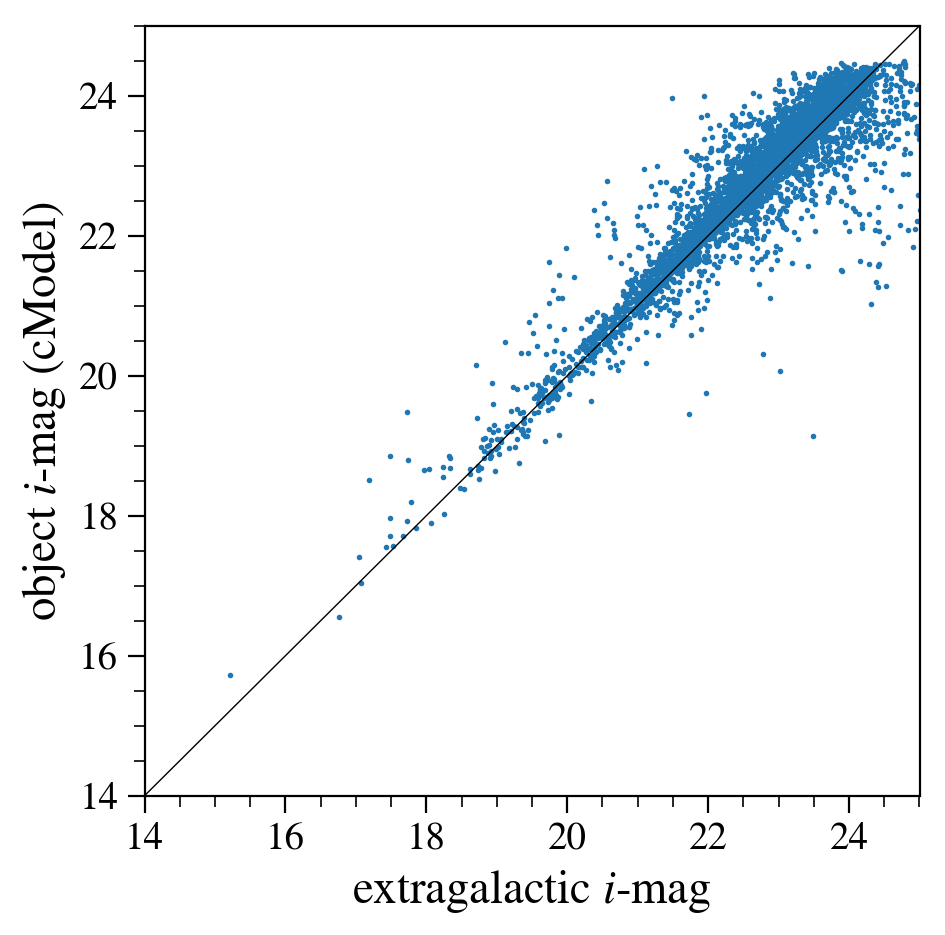

In [28]:
# compare the magnitude
plt.figure(figsize=(5,5));
plt.scatter(matched_gals['mag_i_lsst'], matched_gals['mag_i_cModel'], s=1);
lims = [14, 25]
plt.plot(lims, lims, c='k', lw=0.5);
plt.xlabel('extragalactic $i$-mag');
plt.ylabel('object $i$-mag (cModel)');
plt.xlim(lims);
plt.ylim(lims);

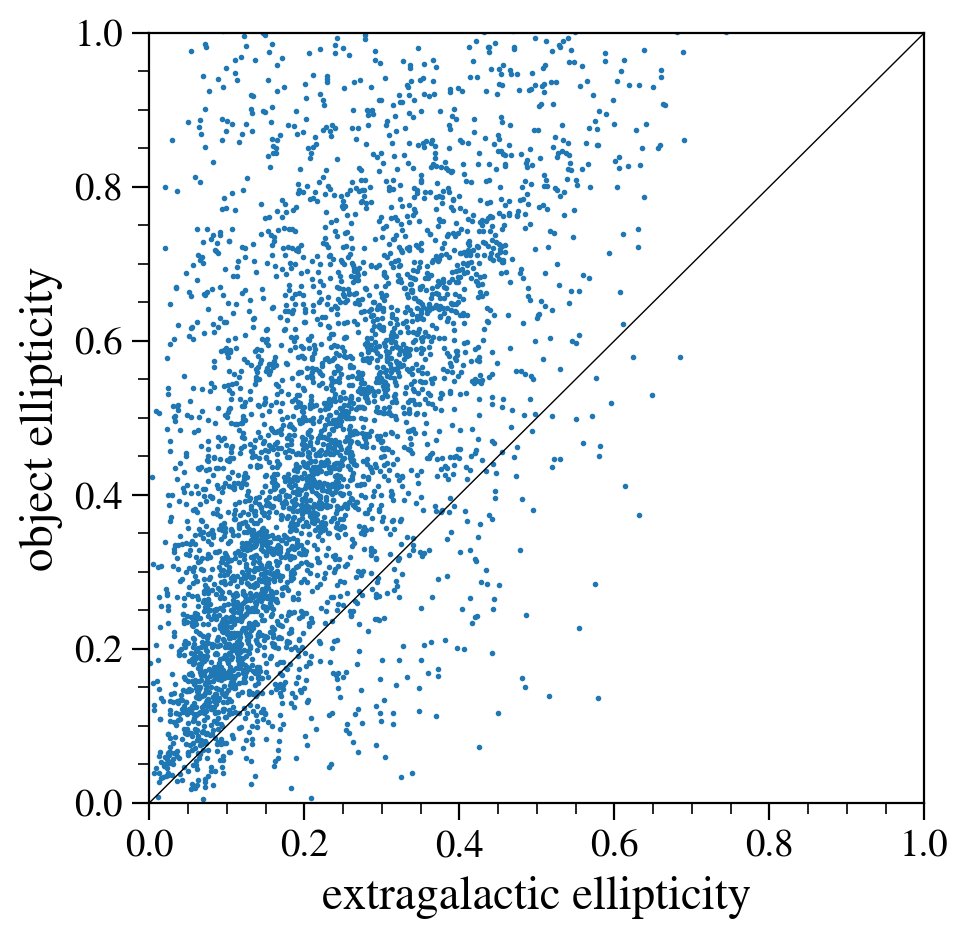

In [29]:
# compare the ellipticity
plt.figure(figsize=(5,5));
plt.scatter(matched_gals['ellipticity_true'], matched_gals['shape_hsm_regauss_etot'], s=1);
lims = [0, 1]
plt.plot(lims, lims, c='k', lw=0.5);
plt.xlabel('extragalactic ellipticity');
plt.ylabel('object ellipticity');
plt.xlim(lims);
plt.ylim(lims);